In [12]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

#from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ
# To be modified: accessing utils

In [13]:
## Copy of utils.py code, not necessary to run if the utils.py from Labs sessions is in the correct location (similar to previous weeks exos) 
async def importFSLasync():
    #load fsl module
    import lmod
    import os
    await lmod.purge(force=True)
    await lmod.load('fsl/6.0.7.4')
    await lmod.list()

def loadFSL():
    """
    Function to load FSL 6.0.7.4 module
    Ensures proper environment variables are setup.
    This function should be called at the start of any
    notebook which relies in any capacity on FSL.
    
    If you wish to change the FSL version being used,
    you should edit within the load AND FSLDIR the version.
    Make sure it exists in the neurodocker image before changing it!
    """
    import asyncio
    import os
    # We need to do the import asynchronously, as modules rely on await within
    #asyncio.run(importFSLasync())
    os.environ["FSLDIR"]="/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.4_20231005/fsl_6.0.7.4_20231005.simg/opt/fsl-6.0.7.4/"
    os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"
    os.environ["SINGULARITY_BINDPATH"]="/data,/neurodesktop-storage,/tmp,/cvmfs"


def mkdir_no_exist(path):
    """
    Function to create a directory if it does not exist already.

    Parameters
    ----------
    path: string
        Path to create
    """
    import os
    import os.path as op
    if not op.isdir(path):
        os.makedirs(path)

class FSLeyesServer:
    """
    An FSL eyes class to manipulate frame and context across notebook.
    
    
    Attributes
    ----------
    overlayList: object
        List of overlays, the images displayed within FSLeyes. Each image is a separate overlay
    displayCtx: object
        Display context
    frame: object
        Frame used to display and interact with FSLeyes
    ortho: object
        View panel in orthographic mode
        
    Examples
    --------
    >>>> %gui wx # Do not forget to use this in a notebook!
    >>>> from utils import FSLeyesServer
    >>>> fsleyesDisplay = FSLeyesServer()
    >>>> fsleyesDisplay.show()
    
    It is not a server in the most proper sense, but merely a convenience wrapper.
    Before initializing this class, always make sure you call %gui wx in a cell of the notebook
    to enable GUI integration.
    """
    def __init__(self):
        import fsleyes
        from fsleyes.views.orthopanel import OrthoPanel
        overlayList, displayCtx, frame = fsleyes.embed()
        ortho = frame.addViewPanel(OrthoPanel)
        self.overlayList = overlayList
        self.displayCtx = displayCtx
        self.frame = frame
        self.ortho = ortho
    def show(self):
        """
        Show the current frame interactively.
        """
        self.frame.Show()

    def setOverlayCmap(self,overlayNbr,cmap):
        self.displayCtx.getOpts(self.overlayList[overlayNbr]).cmap = 'Render3'
    
    def resetOverlays(self):
        """
        Remove all overlays from the current frame
        """
        from fsleyes.views.orthopanel import OrthoPanel
    
        while len(self.overlayList) > 0:
            del self.overlayList[0]

        self.frame.removeViewPanel(self.frame.viewPanels[0])
        # Put back an ortho panel in our viz for future displays
        self.frame.addViewPanel(OrthoPanel)
    
    def load(self,image_path):
        """
        Add a Nifti image to the current frame as a new overlay

        Parameters
        ----------
        image_path:  string
            Path to the Nifti image to add to the frame.
            
        Example
        -------
        >>>> %gui wx # Do not forget to use this in a notebook!
        >>>> from utils import FSLeyesServer
        >>>> fsleyesDisplay = FSLeyesServer() 
        >>>> fsleyesDisplay.load(op.expandvars('$FSLDIR/data/standard/MNI152_T1_0.5mm'))
        >>>> fsleyesDisplay.show()
        """
        from fsl.data.image import Image
        import fsleyes.data.tractogram as trk
        if ".trk" in image_path:
            trk_overlay = trk.Tractogram(image_path)
            self.overlayList.append(trk_overlay)
        else:
            self.overlayList.append(Image(image_path))
    def close(self):
        """
        Closes the server and free up resources.
        """
        import fsleyes
    
        self.frame.Close()
        fsleyes.shutdown()

def fsleyes_thread():
    """
    Function to run the FSLeyesServer in a separate thread.
    This function keeps the server running indefinitely.
    """
    fsleyesDisplay = FSLeyesServer()
    fsleyesDisplay.show()
    
    # Keep the thread alive
    while True:
        time.sleep(1)


def get_json_from_file(fname):
    """
    Given a filename pointing to a json, returns the json's content.

    Parameters
    ----------
    fname: string
        The filename of the json file

    Returns
    -------
    The data of the json file
    """
    import json
    f = open(fname)
    data = json.load(f)
    f.close()
    return data


In [14]:

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [15]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

RuntimeError: Failed to start FSLeyes

## 1.1 Downloading Data

In [ ]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

#download dataset

subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", subject_dir # Effectively get all data
               ], check=True)
###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))

In [89]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))

In [ ]:
print_dir_tree(bids_root, max_depth=4)

## 1.2 Standardizing & Concatenating Data

In [16]:
# Finding the runs matching the structure run-*
fmri_paths = glob.glob(op.join(bids_root,'sub-control01', 'func', 'sub-control01_task-music_run-*_bold.nii.gz'))

# List to hold the standardized data arrays from each run
standardized_fmri_data = []

# Loop through each run file and load it
for i, run_path in enumerate(fmri_paths):
    img = nib.load(run_path)
    data = img.get_fdata()  # Extract the data as a numpy array
    
    # Standardize data (z-scoring)
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    print("Standardizing run {} with mean: {} and std: {}".format(i+1, round(mean,3), round(std,3)))
    
    # Append standardized data for concatenation
    standardized_fmri_data.append(standardized_data)

# Concatenate the standardized runs along the time dimension (4th dimension)
concatenated_data = np.concatenate(standardized_fmri_data, axis=3)

# Create a new NIfTI image for the concatenated data
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))
print("Concatenation complete and saved as concatenated_bold.nii.gz")

Standardizing run 1 with mean: 191.366 and std: 353.0
Standardizing run 2 with mean: 191.214 and std: 352.308
Standardizing run 3 with mean: 191.759 and std: 354.386
Concatenation complete and saved as concatenated_bold.nii.gz


In [17]:
print("Resulting concatenated data has mean: {} and std: {}".format(round(np.mean(concatenated_data),3), round(np.std(concatenated_data),3)))

Resulting concatenated data has mean: -0.0 and std: 1.0


In [97]:
# TO BE REMOVED
print(standardized_fmri_data)

[array([[[[-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         ...,
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259]],

        [[-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         [-0.54211259, -0.54211259, -0.54211259, ..., -0.54211259,
          -0.54211259, -0.54211259],
         ...,
         [-0.54211259, -0.5421125

In [9]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


In [90]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))

## 1.3 Pre-processing Data

### 1.3.PP1 - Motion Correction

In [19]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [20]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--------------- concatenated_bold_moco.nii.gz
|--------------- concatenated_bold_moco.par
|--------------- concatenated_bold_moco.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_eve

In [22]:
# Looking at the time series
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

### Observing the motion correction parameters

In [23]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.010195,0.002236,0.000727,-0.019443,-0.513493,-0.500199
1,-0.011223,0.002433,0.000541,-0.028018,-0.497567,-0.455862
2,-0.010208,0.002210,0.000669,-0.012388,-0.508577,-0.444767
3,-0.010397,0.002093,0.000669,-0.007414,-0.468642,-0.397876
4,-0.010775,0.002037,0.000669,-0.008954,-0.455283,-0.362499
...,...,...,...,...,...,...
310,-0.012110,0.002659,0.001569,0.009786,-0.485361,-0.256989
311,-0.012684,0.002467,0.001490,0.009106,-0.455509,-0.232985
312,-0.012166,0.002322,0.001584,-0.013793,-0.482588,-0.248019
313,-0.012650,0.002224,0.001535,-0.013751,-0.485102,-0.262848


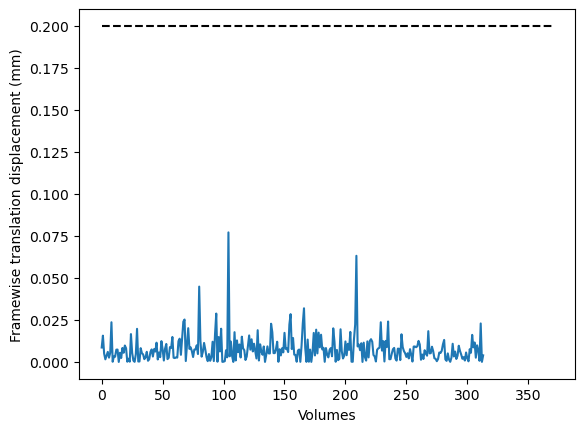

In [24]:
import matplotlib.pyplot as plt
#%matplotlib inline

# Getting the translation and computing the interframe difference  
trans_x = mot_params["Translation x"]
disp_x = np.diff(trans_x)

# Thresholding in absolute value above 0.2mm 
threshold=0.2

#Plotting
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

In [25]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [26]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

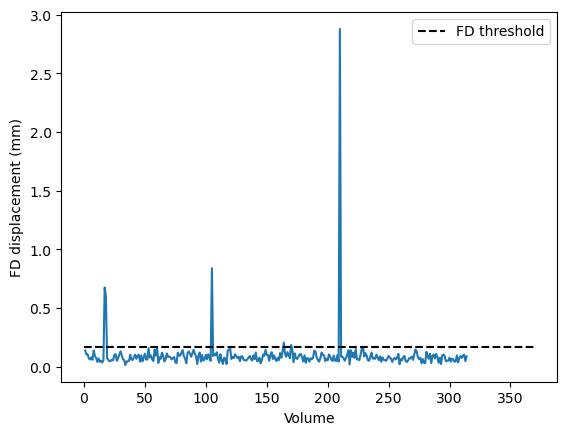

In [27]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [28]:
motion_artifacts = np.where(fd > threshold)[0] + 1
print(motion_artifacts)

[ 17  18 105 164 170 210 229]


### 1.3.PP2 - Smoothing

In [29]:
output_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm'], returncode=0)

In [30]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [31]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ func/
|--------------- concatenated_bold.nii.gz
|--------------- concatenated_bold_moco.nii.gz
|--------------- concatenated_bold_moco.par
|--------------- concatenated_bold_moco_smoothed-6mm.nii.gz
|--------------- concatenated_bold_moco.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_

In [32]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold_moco_smoothed-6mm.nii.gz'))

## ---- End of pre-processing ------

# Applying the GLM at single-subject level

<p style="font-size:25px;">$$Y = X\beta + \epsilon$$</p>


## Design Matrix

In [34]:
# Example data for each run (replace with actual file paths)
#run_paths = ["run1.tsv", "run2.tsv", "run3.tsv"]
df_run_1 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
df_run_2 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
df_run_3 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

dfs = [df_run_1, df_run_2, df_run_3]
dataframes = []
offset = 0

for df in dfs:
    # Adjust onset times
    df['onset'] += offset
    
    # Append the adjusted dataframe
    dataframes.append(df)
    
    # Update offset for next run
    offset = df['onset'].iloc[-1] + df['duration'].iloc[-1]  # End of last event

# Concatenate all runs into one design matrix
df_concatenated = pd.concat(dataframes, ignore_index=True)
df_concatenated.head(56)

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


### Basic Design Matrix (Without drifts and outliers) 

In [67]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

fmri_img = op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold_moco_smoothed-6mm.nii.gz')
# Specify what sort of GLM we want (nature of the noise, TR = 3s of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, df_concatenated)

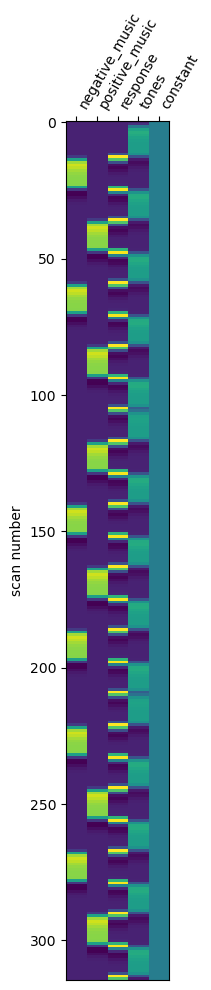

In [36]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

## Including Regressors in the Model

### Including drift

In [38]:
# Creation of the drift model: Order 1-2-3
from nilearn.glm.first_level.design_matrix import _make_drift

# Timing: from t_0 = 0 to t_end = 936 - TR - 1 = 932=> -1 because we start at 0
column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 943, 3))), order=3, high_pass=None)

In [39]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

### Including motion artifacts

In [40]:
print(fd.size)

314


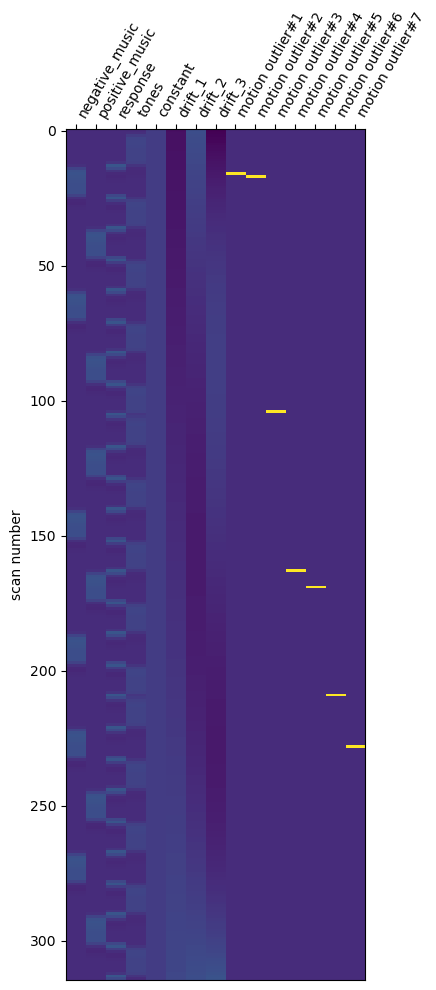

In [41]:
design_mat_regged = design_mat.copy()
volumes_number = fd.size + 1 # Number of volume = timeseries
for i, volume in enumerate(motion_artifacts):
    reg = np.zeros((volumes_number,))*0.0
    reg[volume-1] = 1.0 # adding a regressor at the specific location of the artifact (-1 because we added +1 before)
    design_mat_regged['motion outlier#' + str(i+1)] = reg

plot_design_matrix(design_mat_regged)
plt.show()

### Fitting the new glm

In [110]:
fit_glm = FirstLevelModel(t_r=3,
                           drift_model='None',
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.01)

# Fit the model to our design and data
fit_glm = fit_glm.fit(fmri_img, design_matrices=[design_mat_regged] )

## Building the contrast

[-1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
(315, 15)


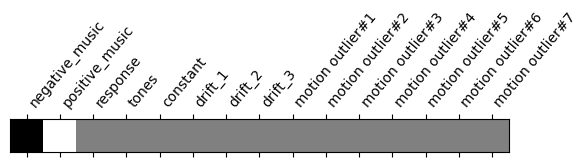

In [112]:


# Initialize contrast with values for "positive_music" and "negative_music" and pad with zeros for other columns
positive_minus_negative = np.array([-1, 1] + [0] * (design_mat_regged.shape[1] - 2))

# Plot the contrast matrix
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat_regged)


#REMOVE PRINTS
print(positive_minus_negative)
print(design_mat_regged.shape)

In [115]:
#z-score map of the beta coefficients of active minus rest
import nibabel as nib
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

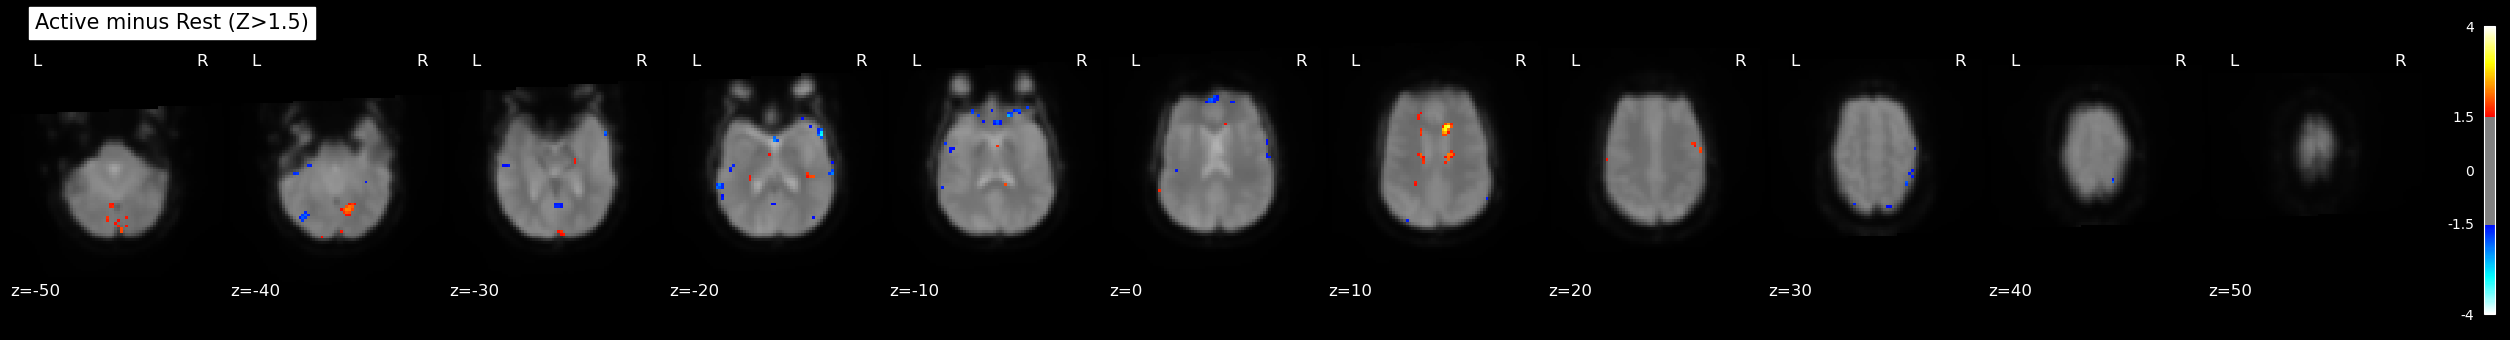

In [127]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
threshold=1.5
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

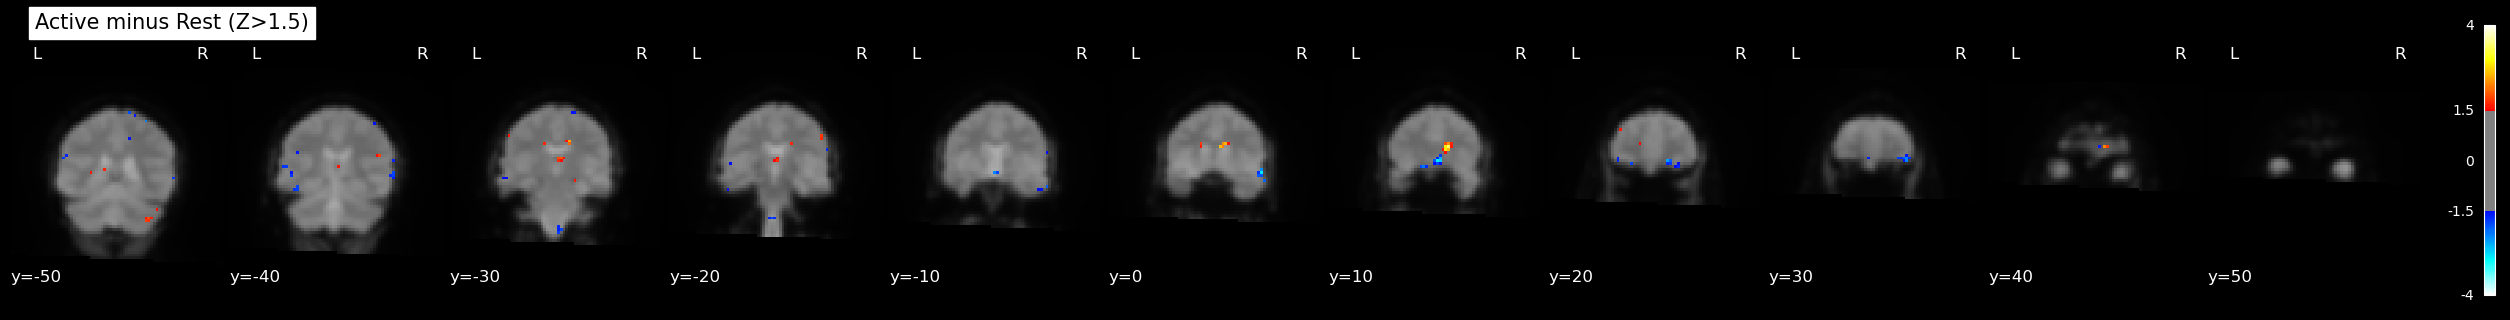

In [128]:
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='y', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

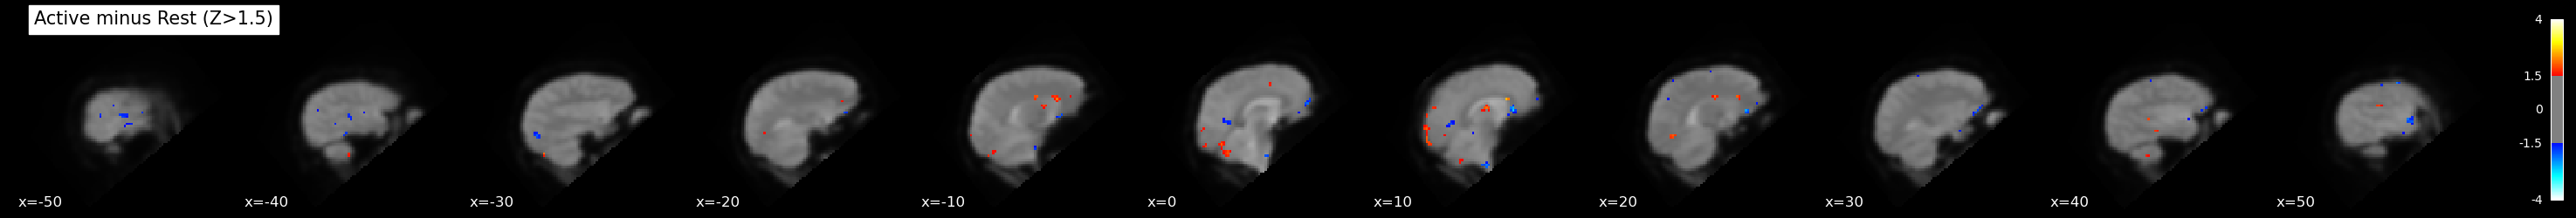

In [129]:
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='x', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

/opt/conda/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.012554207478685. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


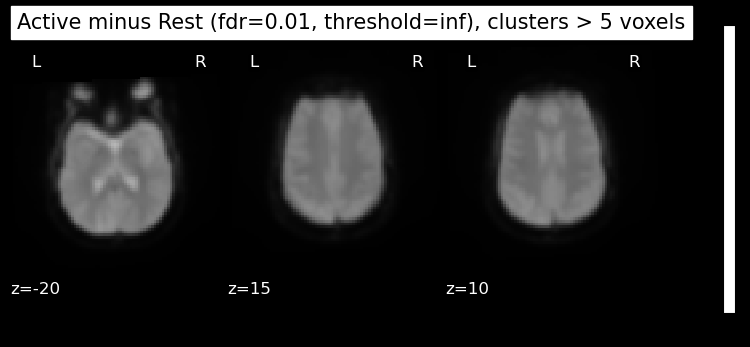

In [117]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 5 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.01 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-20,15,10], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()